In [ ]:
import torch
from torch import Tensor
print(torch.__version__)

2.0.1+cu118


In [ ]:
import numpy as np
import pickle
import gzip
import sys

In [ ]:
torch.cuda.empty_cache()
print(torch.cuda.memory_allocated() / 1024**2, 'MB')

0.0 MB


In [ ]:
import gc
gc.collect()

0

In [ ]:
# Install required packages.
import os
os.environ['TORCH'] = torch.__version__

!pip install torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install pyg-lib -f https://data.pyg.org/whl/nightly/torch-${TORCH}.html
!pip install git+https://github.com/pyg-team/pytorch_geometric.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://data.pyg.org/whl/torch-2.0.1+cu118.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 63.8 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://data.pyg.org/whl/torch-2.0.1+cu118.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 82.8 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://data.pyg.org/whl/nightly/torch-2.0.1+cu118.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 4.6 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/pyg-team/pytorch_geometric.git to /tmp/pip-req-build-agmvvdf4
  Running command git clone --filter=blob:none --quiet https://github

# Link Prediction on Yelp

This colab notebook shows how to load a set of `*.csv` files as input and construct a heterogeneous graph from it.
We will then use this dataset as input into a [heterogeneous graph model](https://pytorch-geometric.readthedocs.io/en/latest/notes/heterogeneous.html#hgtutorial), and use it for the task of link prediction.
A few code cells require user input to let the code run through successfully.
Parts of this tutorial are also available in [our documentation](https://pytorch-geometric.readthedocs.io/en/latest/notes/load_csv.html).

We are going to use the [MovieLens dataset](https://grouplens.org/datasets/movielens/) collected by the GroupLens research group.
This toy dataset describes ratings and tagging activity from MovieLens.
The dataset contains approximately 100k ratings across more than 9k movies from more than 600 users.
We are going to use this dataset to generate two node types holding data for movies and users, respectively, and one edge type connecting users and movies, representing the relation of whether a user has rated a specific movie.

The link prediction task then tries to predict missing ratings, and can, for example, be used to recommend users new movies.

## Heterogeneous Graph Creation

First, we download the dataset to an arbitrary folder (in this case, the current directory):

In [ ]:
import torch_geometric
from torch_geometric.data import download_url, extract_zip

business_path = './business_pa1.csv.gz'
reviews_path = './reviews_ph1.csv.gz'
coor_path = './coor_df.csv.gz'

Before we create the heterogeneous graph, let’s take a look at the data.

In [ ]:
import pandas as pd

print('business.csv:')
print('===========')
print(pd.read_csv(business_path)[["business_id", "categories"]].head())
print()
print('reviews.csv:')
print('============')
print(pd.read_csv(reviews_path)[["user_id", "business_id"]].head())

business.csv:
              business_id                                         categories
0  MTSW4McQd7CbVtyjqoe9mw  Restaurants|Food|Bubble Tea|Coffee & Tea|Bakeries
1  MUTTqe8uqyMdBl186RmNeA                    Sushi Bars|Restaurants|Japanese
2  ROeacJQwBeh05Rqg7F6TCg                                 Korean|Restaurants
3  aPNXGTDkf-4bjhyMBQxqpQ  Eatertainment|Arts & Entertainment|Brewpubs|Am...
4  ppFCk9aQkM338Rgwpl2F5A  Restaurants|Automotive|Delis|Gas Stations|Food...

reviews.csv:
                  user_id             business_id
0  _7bHUi9Uuf5__HHc_Q8guQ  kxX2SOes4o-D3ZQBkiMRfA
1  Dd1jQj7S-BFGqRbApFzCFw  YtSqYv1Q_pOltsVPSx54SA
2  IQsF3Rc6IgCzjVV9DE8KXg  eFvzHawVJofxSnD7TgbZtg
3  vrKkXsozqqecF3CW4cGaVQ  rjuWz_AD3WfXJc03AhIO_w
4  aFa96pz67TwOFu4Weq5Agg  kq5Ghhh14r-eCxlVmlyd8w


We see that the `movies.csv` file provides two useful columns: `movieId` assigns a unique identifier to each movie, while the `genres` column represent genres of the given movie.
We can make use of this column to define a feature representation that can be easily interpreted by machine learning models.

In [ ]:
# Load the entire business data frame into memory:
business_df = pd.read_csv(business_path, index_col='business_id')

# Split categories and convert into indicator variables:
categories = business_df['categories'].str.get_dummies('|')
print(categories[["Restaurants", "Food", "Sushi Bars", "Italian"]].head())

# Use categories as business input features:
business_feat = torch.from_numpy(categories.values).to(torch.float)
assert business_feat.size() == (8148, 957)  # 957 categories in total.

                        Restaurants  Food  Sushi Bars  Italian
business_id                                                   
MTSW4McQd7CbVtyjqoe9mw            1     1           0        0
MUTTqe8uqyMdBl186RmNeA            1     0           1        0
ROeacJQwBeh05Rqg7F6TCg            1     0           0        0
aPNXGTDkf-4bjhyMBQxqpQ            1     1           0        0
ppFCk9aQkM338Rgwpl2F5A            1     1           0        0


The `ratings.csv` data connects users (as given by `userId`) and movies (as given by `movieId`).
Due to simplicity, we do not make use of the additional `timestamp` and `rating` information.
Here, we first read the `*.csv` file from disk, and create a mapping that maps entry IDs to a consecutive value in the range `{ 0, ..., num_rows - 1 }`.
This is needed as we want our final data representation to be as compact as possible, *e.g.*, the representation of a movie in the first row should be accessible via `x[0]`.

Afterwards, we obtain the final `edge_index` representation of shape `[2, num_ratings]` from `ratings.csv` by merging mapped user and movie indices with the raw indices given by the original data frame.

In [ ]:
# Load the entire ratings data frame into memory:
reviews_df = pd.read_csv(reviews_path)

# Create a mapping from unique user indices to range [0, num_user_nodes):
unique_user_id = reviews_df['user_id'].unique()
unique_user_id = pd.DataFrame(data={
    'user_id': unique_user_id,
    'mappedID': pd.RangeIndex(len(unique_user_id)),
})


print("Mapping of user IDs to consecutive values:")
print("==========================================")
print(unique_user_id.head())
print()
# Create a mapping from unique movie indices to range [0, num_movie_nodes):
unique_business_id = pd.DataFrame(data={
    'business_id': business_df.index,
    'mappedID': pd.RangeIndex(len(business_df)),
})


print("Mapping of business IDs to consecutive values:")
print("===========================================")
print(unique_business_id.head())

# Perform merge to obtain the edges from users and movies:
ratings_user_id = pd.merge(reviews_df['user_id'], unique_user_id,
                            left_on='user_id', right_on='user_id', how='left')
ratings_user_id = torch.from_numpy(ratings_user_id['mappedID'].values)
ratings_business_id = pd.merge(reviews_df['business_id'], unique_business_id,
                            left_on='business_id', right_on='business_id', how='left')
ratings_business_id = torch.from_numpy(ratings_business_id['mappedID'].values)

# With this, we are ready to construct our `edge_index` in COO format
# following PyG semantics:
edge_index_user_to_business = torch.stack([ratings_user_id, ratings_business_id], dim=0)

assert edge_index_user_to_business.size() == (2,694647)

print()
print("Final edge indices pointing from users to busness:")
print("=================================================")
print(edge_index_user_to_business)

Mapping of user IDs to consecutive values:
                  user_id  mappedID
0  _7bHUi9Uuf5__HHc_Q8guQ         0
1  Dd1jQj7S-BFGqRbApFzCFw         1
2  IQsF3Rc6IgCzjVV9DE8KXg         2
3  vrKkXsozqqecF3CW4cGaVQ         3
4  aFa96pz67TwOFu4Weq5Agg         4

Mapping of business IDs to consecutive values:
              business_id  mappedID
0  MTSW4McQd7CbVtyjqoe9mw         0
1  MUTTqe8uqyMdBl186RmNeA         1
2  ROeacJQwBeh05Rqg7F6TCg         2
3  aPNXGTDkf-4bjhyMBQxqpQ         3
4  ppFCk9aQkM338Rgwpl2F5A         4

Final edge indices pointing from users to busness:
tensor([[     0,      1,      2,  ...,  39627, 232201,    633],
        [   346,    638,    261,  ...,   7673,   7790,   7976]])


In [ ]:
print(len(set(reviews_df['business_id'].unique()).difference(business_df.index.values)))
assert(len(set(reviews_df['business_id'].unique()).difference(business_df.index.values)) == 0)

0


With this, we are ready to initialize our `HeteroData` object and pass the necessary information to it.
Note that we also pass in a `node_id` vector to each node type in order to reconstruct the original node indices from sampled subgraphs.
We also take care of adding reverse edges to the `HeteroData` object.
This allows our GNN model to use both directions of the edge for message passing:

In [ ]:
from torch_geometric.data import HeteroData
import torch_geometric.transforms as T

In [ ]:
data = HeteroData()

# Save node indices:

data["user_id"].node_id = torch.arange(len(unique_user_id))
data["business_id"].node_id = torch.arange(len(business_df))

# Add the node features and edge indices:

data["business_id"].x =business_feat
data["user_id", "stars", "business_id"].edge_index = edge_index_user_to_business

#to make sure to add the reverse edges from movies to users
# in order to let a GNN be able to pass messages in both directions.
# We can leverage the `T.ToUndirected()` transform for this from PyG:

data = T.ToUndirected()(data)

print(data)

assert data.node_types == ["user_id", "business_id"]

assert data.edge_types == [("user_id", "stars", "business_id"),("business_id", "rev_stars", "user_id")]

assert data["user_id"].num_nodes == 232202
assert data["user_id"].num_features == 0
assert data["business_id"].num_nodes == 8148
assert data["business_id"].num_features == 957
assert data["user_id", "stars", "business_id"].num_edges ==694647
assert data["business_id", "rev_stars", "user_id"].num_edges == 694647

HeteroData(
  user_id={ node_id=[232202] },
  business_id={
    node_id=[8148],
    x=[8148, 957],
  },
  (user_id, stars, business_id)={ edge_index=[2, 694647] },
  (business_id, rev_stars, user_id)={ edge_index=[2, 694647] }
)


In questa versione aggiungo anche le coordinate spaziali

In [ ]:
from torch_geometric.data import HeteroData
import torch

# Load the entire business data frame into memory:
business_df = pd.read_csv(business_path, index_col='business_id')

# Split categories and convert into indicator variables:
categories = business_df['categories'].str.get_dummies('|')
business_feat = torch.from_numpy(categories.values).to(torch.float)

# Load the entire ratings data frame into memory:
reviews_df = pd.read_csv(reviews_path)

# Load coordinate:

coor_df= pd.read_csv(coor_path)

# Create a mapping from unique user indices to range [0, num_user_nodes):
unique_user_id = reviews_df['user_id'].unique()
unique_user_id = pd.DataFrame(data={
    'user_id': unique_user_id,
    'mappedID': pd.RangeIndex(len(unique_user_id)),
})

# Create a mapping from unique business indices to range [0, num_business_nodes):
unique_business_id = pd.DataFrame(data={
    'business_id': business_df.index,
    'mappedID': pd.RangeIndex(len(business_df)),
})

# Perform merge to obtain the edges from users and businesses:
ratings_user_id = pd.merge(reviews_df['user_id'], unique_user_id,
                            left_on='user_id', right_on='user_id', how='left')
ratings_user_id = torch.from_numpy(ratings_user_id['mappedID'].values)
ratings_business_id = pd.merge(reviews_df['business_id'], unique_business_id,
                            left_on='business_id', right_on='business_id', how='left')
ratings_business_id = torch.from_numpy(ratings_business_id['mappedID'].values)

# With this, we are ready to construct our `edge_index` in COO format
# following PyG semantics:
edge_index_user_to_business = torch.stack([ratings_user_id, ratings_business_id], dim=0)

# Extract the unique user coordinates
unique_user_coor_df = coor_df.drop_duplicates(subset=['user_id'])[['user_id', 'user_latitude', 'user_longitude']]
user_coor = unique_user_coor_df[["user_latitude", "user_longitude"]].values

# Extract the unique business coordinates
business_coor = business_df[["latitude", "longitude"]].values

# Create the HeteroData object with node features, edge indices, and coordinate tensors
data = HeteroData()

# Save node indices
data["user_id"].node_id = torch.arange(len(unique_user_id))
data["business_id"].node_id = torch.arange(len(business_df))

# Add the node features and edge indices
data["business_id"].x = business_feat
data["user_id", "stars", "business_id"].edge_index = edge_index_user_to_business

# Add coordinate tensors
data["user_id"].pos = torch.tensor(user_coor, dtype=torch.float)
data["business_id"].pos = torch.tensor(business_coor, dtype=torch.float)

# Apply the ToUndirected transform
data = T.ToUndirected()(data)


print(data)

assert data.node_types == ["user_id", "business_id"]

assert data.edge_types == [("user_id", "stars", "business_id"),("business_id", "rev_stars", "user_id")]

assert data["user_id"].num_nodes == 232202
assert data["user_id"].num_features == 0
assert data["business_id"].num_nodes == 8148
assert data["business_id"].num_features == 957
assert data["user_id", "stars", "business_id"].num_edges ==694647
assert data["business_id", "rev_stars", "user_id"].num_edges == 694647

HeteroData(
  user_id={
    node_id=[232202],
    pos=[232202, 2],
  },
  business_id={
    node_id=[8148],
    x=[8148, 957],
    pos=[8148, 2],
  },
  (user_id, stars, business_id)={ edge_index=[2, 694647] },
  (business_id, rev_stars, user_id)={ edge_index=[2, 694647] }
)


## Defining Edge-level Training Splits

Since our data is now ready-to-be-used, we can split the ratings of users into training, validation, and test splits.
This is needed in order to ensure that we leak no information about edges used during evaluation into the training phase.
For this, we make use of the [`transforms.RandomLinkSplit`](https://pytorch-geometric.readthedocs.io/en/latest/modules/transforms.html#torch_geometric.transforms.RandomLinkSplit) transformation from PyG.
This transforms randomly divides the edges in the `("user", "rates", "movie")` into training, validation and test edges.
The `disjoint_train_ratio` parameter further separates edges in the training split into edges used for message passing (`edge_index`) and edges used for supervision (`edge_label_index`).
Note that we also need to specify the reverse edge type `("movie", "rev_rates", "user")`.
This allows the `RandomLinkSplit` transform to drop reverse edges accordingly to not leak any information into the training phase.

In [ ]:
# For this, we first split the set of edges into
# training (80%), validation (10%), and testing edges (10%).
# Across the training edges, we use 70% of edges for message passing,
# and 30% of edges for supervision.
# We further want to generate fixed negative edges for evaluation with a ratio of 2:1.
# Negative edges during training will be generated on-the-fly.
# We can leverage the `RandomLinkSplit()` transform for this from PyG:

transform = T.RandomLinkSplit(
    num_val=0.1,
    num_test=0.1,
    disjoint_train_ratio= 0.3,
    neg_sampling_ratio=2,
    add_negative_train_samples=False,
    edge_types=("user_id", "stars", "business_id"),
    rev_edge_types=("business_id", "rev_stars", "user_id"), 
)

train_data, val_data, test_data = transform(data)

print("Training data:")
print("==============")
print(train_data)
print()
print("Validation data:")
print("================")
print(val_data)
print("Test data:")
print("================")
print(test_data)

assert train_data["user_id", "stars", "business_id"].num_edges == 389004
assert train_data["user_id", "stars", "business_id"].edge_label_index.size(1) == 166715
assert train_data["business_id", "rev_stars", "user_id"].num_edges == 389004
# No negative edges added:

assert train_data["user_id", "stars", "business_id"].edge_label.min() == 1  
assert train_data["user_id", "stars", "business_id"].edge_label.max() == 1

assert val_data["user_id", "stars", "business_id"].num_edges == 555719
assert val_data["user_id", "stars", "business_id"].edge_label_index.size(1) == 208392 
assert val_data["business_id", "rev_stars", "user_id"].num_edges == 555719

# Negative edges with ratio 2:1:

assert val_data["user_id", "stars", "business_id"].edge_label.long().bincount().tolist() == [138928, 69464]

Training data:
HeteroData(
  user_id={
    node_id=[232202],
    pos=[232202, 2],
  },
  business_id={
    node_id=[8148],
    x=[8148, 957],
    pos=[8148, 2],
  },
  (user_id, stars, business_id)={
    edge_index=[2, 389004],
    edge_label=[166715],
    edge_label_index=[2, 166715],
  },
  (business_id, rev_stars, user_id)={ edge_index=[2, 389004] }
)

Validation data:
HeteroData(
  user_id={
    node_id=[232202],
    pos=[232202, 2],
  },
  business_id={
    node_id=[8148],
    x=[8148, 957],
    pos=[8148, 2],
  },
  (user_id, stars, business_id)={
    edge_index=[2, 555719],
    edge_label=[208392],
    edge_label_index=[2, 208392],
  },
  (business_id, rev_stars, user_id)={ edge_index=[2, 555719] }
)
Test data:
HeteroData(
  user_id={
    node_id=[232202],
    pos=[232202, 2],
  },
  business_id={
    node_id=[8148],
    x=[8148, 957],
    pos=[8148, 2],
  },
  (user_id, stars, business_id)={
    edge_index=[2, 625183],
    edge_label=[208392],
    edge_label_index=[2, 208392],


## Defining Mini-batch Loaders

We are now ready to create a mini-batch loader that will generate subgraphs that can be used as input into our GNN.
While this step is not strictly necessary for small-scale graphs, it is absolutely necessary to apply GNNs on larger graphs that do not fit onto GPU memory otherwise.
Here, we make use of the [`loader.LinkNeighborLoader`](https://pytorch-geometric.readthedocs.io/en/latest/modules/loader.html#torch_geometric.loader.LinkNeighborLoader) which samples multiple hops from both ends of a link and creates a subgraph from it.
Here, `edge_label_index` serves as the "seed links" to start sampling from.

In [ ]:
# In the first hop, we sample at most 20 neighbors.
# In the second hop, we sample at most 10 neighbors.
# In addition, during training, we want to sample negative edges on-the-fly with
# a ratio of 2:1.
# We can make use of the `loader.LinkNeighborLoader` from PyG:

from torch_geometric.loader import LinkNeighborLoader

# Define seed edges:
edge_label_index = train_data["user_id", "stars", "business_id"].edge_label_index
edge_label = train_data["user_id", "stars", "business_id"].edge_label

train_loader = LinkNeighborLoader(
    data=train_data,
    num_neighbors=[20,10],
    neg_sampling_ratio=2.0,
    edge_label_index=(("user_id", "stars", "business_id"), edge_label_index),
    edge_label=edge_label,
    batch_size=128,
    shuffle=True,
    )


In [ ]:
# Inspect a sample:
sampled_data = next(iter(train_loader))

print("Sampled mini-batch:")
print("===================")
print(sampled_data)

assert sampled_data["user_id", "stars", "business_id"].edge_label_index.size(1) == 3 * 128
assert sampled_data["user_id", "stars", "business_id"].edge_label.min() == 0
assert sampled_data["user_id", "stars", "business_id"].edge_label.max() == 1 

Sampled mini-batch:
HeteroData(
  user_id={
    node_id=[11525],
    pos=[11525, 2],
    n_id=[11525],
  },
  business_id={
    node_id=[4602],
    x=[4602, 957],
    pos=[4602, 2],
    n_id=[4602],
  },
  (user_id, stars, business_id)={
    edge_index=[2, 13386],
    edge_label=[384],
    edge_label_index=[2, 384],
    e_id=[13386],
    input_id=[128],
  },
  (business_id, rev_stars, user_id)={
    edge_index=[2, 23760],
    e_id=[23760],
  }
)


## Evaluating a Heterogeneous Link-level GNN

After training, we evaluate our model on useen data coming from the validation set.
For this, we define a new `LinkNeighborLoader` (which now iterates over the edges in the validation set), obtain the predictions on validation edges by running the model, and finally evaluate the performance of the model by computing the AUC score over the set of predictions and their corresponding ground-truth edges (including both positive and negative edges).

In [ ]:
# Define the validation seed edges:
edge_label_index = val_data["user_id", "stars", "business_id"].edge_label_index
edge_label = val_data["user_id", "stars", "business_id"].edge_label

val_loader = LinkNeighborLoader(
    data=val_data,
    num_neighbors=[20, 10],
    edge_label_index=(("user_id", "stars", "business_id"), edge_label_index),
    edge_label=edge_label,
    batch_size=3 * 128,
    shuffle=False,
)

sampled_data1= next(iter(val_loader))

print("Sampled mini-batch:")
print("===================")
print(sampled_data1)


assert sampled_data1["user_id", "stars", "business_id"].edge_label_index.size(1) == 3 * 128
assert sampled_data1["user_id", "stars", "business_id"].edge_label.min() >= 0
assert sampled_data1["user_id", "stars", "business_id"].edge_label.max() <= 1

Sampled mini-batch:
HeteroData(
  user_id={
    node_id=[16387],
    pos=[16387, 2],
    n_id=[16387],
  },
  business_id={
    node_id=[4882],
    x=[4882, 957],
    pos=[4882, 2],
    n_id=[4882],
  },
  (user_id, stars, business_id)={
    edge_index=[2, 20635],
    edge_label=[384],
    edge_label_index=[2, 384],
    e_id=[20635],
    input_id=[384],
  },
  (business_id, rev_stars, user_id)={
    edge_index=[2, 32623],
    e_id=[32623],
  }
)


## Creating a Heterogeneous Link-level GNN

We are now ready to create our heterogeneous GNN.
The GNN is responsible for learning enriched node representations from the surrounding subgraphs, which can be then used to derive edge-level predictions.
For defining our heterogenous GNN, we make use of [`nn.SAGEConv`](https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html#torch_geometric.nn.conv.SAGEConv) and the [`nn.to_hetero()`](https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html#torch_geometric.nn.to_hetero_transformer.to_hetero) function, which transforms a GNN defined on homogeneous graphs to be applied on heterogeneous ones.

In addition, we define a final link-level classifier, which simply takes both node embeddings of the link we are trying to predict, and applies a dot-product on them.

As users do not have any node-level information, we choose to learn their features jointly via a `torch.nn.Embedding` layer. In order to improve the expressiveness of movie features, we do the same for movie nodes, and simply add their shallow embeddings to the pre-defined genre features.

In [ ]:
from torch_geometric.nn import SAGEConv, to_hetero
import torch.nn
import torch.nn.functional as F  # aggiungo questo import


class GNN(torch.nn.Module):
    def __init__(self, hidden_channels,dropout_rate):
        super().__init__()

        self.conv1 = SAGEConv(hidden_channels, hidden_channels)
        self.dropout = torch.nn.Dropout(dropout_rate)
        self.conv2 = SAGEConv(hidden_channels, hidden_channels)
     

    def forward(self, x: Tensor, edge_index: Tensor) -> Tensor:
        
        # La funzione applica una funzione di attivazione ReLU al primo layer di convoluzione, 
        # quindi applica il secondo layer di convoluzione senza attivazione.
        # aggiungo dropout per regolarizzare
        
        x = F.relu(self.conv1(x, edge_index))
        x = self.dropout(x)             
        x = self.conv2(x, edge_index)
        return x 


In [ ]:
# Our final classifier applies the dot-product between source and destination
# node embeddings to derive edge-level predictions:
class Classifier(torch.nn.Module):
    def forward(self, x_user: Tensor, x_business: Tensor, edge_label_index: Tensor) -> Tensor:
        # Convert node embeddings to edge-level representations:
        
        edge_feat_user = x_user[edge_label_index[0]]    # source nodes
        edge_feat_business = x_business[edge_label_index[1]]  # targets nodes
        

        # Apply dot-product to get a prediction per supervision edge:
        
        return (edge_feat_user * edge_feat_business).sum(dim=-1)
        

In [ ]:
class Model(torch.nn.Module):
    def __init__(self, hidden_channels,dropout_rate):
        super().__init__()
        # Since the dataset does not come with rich features, we also learn two
        # embedding matrices for users and business:
        
        self.business_lin = torch.nn.Linear(957, hidden_channels)  
        self.user_emb = torch.nn.Embedding(data["user_id"].num_nodes, hidden_channels)
        self.business_emb = torch.nn.Embedding(data["business_id"].num_nodes, hidden_channels)

        # Instantiate homogeneous GNN:
        
        self.gnn = GNN(hidden_channels,dropout_rate)
        self.dropout = torch.nn.Dropout(p=dropout_rate)  # <--- Aggiunta della dropout layer
        
        # Convert GNN model into a heterogeneous variant:
        
        self.gnn = to_hetero(self.gnn, metadata=data.metadata())

        self.classifier = Classifier()

    def forward(self, data: HeteroData) -> Tensor:
        x_dict = {
          "user_id": self.user_emb(data["user_id"].node_id),
          "business_id": self.business_lin(data["business_id"].x) + self.business_emb(data["business_id"].node_id),
        } 

        # `x_dict` holds feature matrices of all node types
        # `edge_index_dict` holds all edge indices of all edge types
        
        x_dict = self.gnn(x_dict, data.edge_index_dict)

        pred = self.classifier(
            x_dict["user_id"],
            x_dict["business_id"],
            data["user_id", "stars", "business_id"].edge_label_index,
        )
        
        return pred
model = Model(hidden_channels=64,dropout_rate=0.5)

print(model)

Model(
  (business_lin): Linear(in_features=957, out_features=64, bias=True)
  (user_emb): Embedding(232202, 64)
  (business_emb): Embedding(8148, 64)
  (gnn): GraphModule(
    (conv1): ModuleDict(
      (user_id__stars__business_id): SAGEConv(64, 64, aggr=mean)
      (business_id__rev_stars__user_id): SAGEConv(64, 64, aggr=mean)
    )
    (dropout): ModuleDict(
      (user_id): Dropout(p=0.5, inplace=False)
      (business_id): Dropout(p=0.5, inplace=False)
    )
    (conv2): ModuleDict(
      (user_id__stars__business_id): SAGEConv(64, 64, aggr=mean)
      (business_id__rev_stars__user_id): SAGEConv(64, 64, aggr=mean)
    )
  )
  (dropout): Dropout(p=0.5, inplace=False)
  (classifier): Classifier()
)


## Training a Heterogeneous Link-level GNN

Training our GNN is then similar to training any PyTorch model.
We move the model to the desired device, and initialize an optimizer that takes care of adjusting model parameters via stochastic gradient descent.

The training loop then iterates over our mini-batches, applies the forward computation of the model, computes the loss from ground-truth labels and obtained predictions (here we make use of binary cross entropy), and adjusts model parameters via back-propagation and stochastic gradient descent.

# Nuova Logica GCN

La principale differenza tra i due modelli è l'utilizzo di diversi tipi di layer di convoluzione (SAGEConv vs GCNConv).Inoltre, nel secondo modello, sono state aggiunte alcune righe per disabilitare l'aggiunta di self-loop nei layer di convoluzione GCNConv.

In [ ]:
from torch_geometric.nn import GCNConv
from torch_geometric.nn import to_hetero
import torch.nn.functional as F 

class GNN(torch.nn.Module):
    def __init__(self, hidden_channels, dropout_rate):
        super().__init__()

        self.conv1 = GCNConv(hidden_channels, hidden_channels)
        self.dropout = torch.nn.Dropout(dropout_rate)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
     
    def forward(self, x: Tensor, edge_index: Tensor) -> Tensor:
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.conv2(x, edge_index)
        return x


In [ ]:
# Our final classifier applies the dot-product between source and destination
# node embeddings to derive edge-level predictions:
class Classifier(torch.nn.Module):
    def forward(self, x_user: Tensor, x_business: Tensor, edge_label_index: Tensor) -> Tensor:
        # Convert node embeddings to edge-level representations:
        
        edge_feat_user = x_user[edge_label_index[0]]    # source nodes
        edge_feat_business = x_business[edge_label_index[1]]  # targets nodes
        

        # Apply dot-product to get a prediction per supervision edge:
        
        return (edge_feat_user * edge_feat_business).sum(dim=-1)

In [ ]:
class Model(torch.nn.Module):
    def __init__(self, hidden_channels,dropout_rate):
        super().__init__()
        # Since the dataset does not come with rich features, we also learn two
        # embedding matrices for users and business:
        
        self.business_lin = torch.nn.Linear(957, hidden_channels)  
        self.user_emb = torch.nn.Embedding(data["user_id"].num_nodes, hidden_channels)
        self.business_emb = torch.nn.Embedding(data["business_id"].num_nodes, hidden_channels)

        # Instantiate homogeneous GNN:
        
        self.gnn = GNN(hidden_channels,dropout_rate)
        
        self.gnn = GNN(hidden_channels, dropout_rate)
        self.gnn.conv1.add_self_loops = False
        self.gnn.conv2.add_self_loops = False


        self.dropout = torch.nn.Dropout(p=dropout_rate)  # <--- Aggiunta della dropout layer
        
        # Convert GNN model into a heterogeneous variant:
        
        self.gnn = to_hetero(self.gnn, metadata=data.metadata())

        self.classifier = Classifier()

    def forward(self, data: HeteroData) -> Tensor:
        x_dict = {
          "user_id": self.user_emb(data["user_id"].node_id),
          "business_id": self.business_lin(data["business_id"].x) + self.business_emb(data["business_id"].node_id),
        } 

        # `x_dict` holds feature matrices of all node types
        # `edge_index_dict` holds all edge indices of all edge types
        
        x_dict = self.gnn(x_dict, data.edge_index_dict)

        pred = self.classifier(
            x_dict["user_id"],
            x_dict["business_id"],
            data["user_id", "stars", "business_id"].edge_label_index,
        )
        
        return pred
model = Model(hidden_channels=64,dropout_rate=0.5)

print(model)

Model(
  (business_lin): Linear(in_features=957, out_features=64, bias=True)
  (user_emb): Embedding(232202, 64)
  (business_emb): Embedding(8148, 64)
  (gnn): GraphModule(
    (conv1): ModuleDict(
      (user_id__stars__business_id): GCNConv(64, 64)
      (business_id__rev_stars__user_id): GCNConv(64, 64)
    )
    (dropout): ModuleDict(
      (user_id): Dropout(p=0.5, inplace=False)
      (business_id): Dropout(p=0.5, inplace=False)
    )
    (conv2): ModuleDict(
      (user_id__stars__business_id): GCNConv(64, 64)
      (business_id__rev_stars__user_id): GCNConv(64, 64)
    )
  )
  (dropout): Dropout(p=0.5, inplace=False)
  (classifier): Classifier()
)


modo senza learning curve

In [ ]:
import tqdm

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: '{device}'")

model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

for epoch in range(1, 9):
    total_loss = total_examples = 0
    for sampled_data in tqdm.tqdm(train_loader):
        optimizer.zero_grad()

        # Move `sampled_data` to the respective `device`
        sampled_data=sampled_data.to(device)

        # Run `forward` pass of the model
        pred = model(sampled_data)

        ground_truth = sampled_data["user_id", "stars", "business_id"].edge_label

        # Apply binary cross entropy via `F.binary_cross_entropy_with_logits(pred, ground_truth)`
        loss = F.binary_cross_entropy_with_logits(pred, ground_truth)

        loss.backward()
        optimizer.step()
        total_loss += float(loss) * pred.numel()
        total_examples += pred.numel()
    print(f"Epoch: {epoch:03d}, Loss: {total_loss / total_examples:.4f}")


Device: 'cpu'


  0%|          | 0/1303 [00:00<?, ?it/s]


AttributeError: ignored

In [ ]:
from sklearn.metrics import roc_auc_score


preds = []
ground_truths = []
for sampled_data in tqdm.tqdm(val_loader):
    with torch.no_grad():
        # Business data to device
        
        sampled_data.to(device)
        preds.append(model(sampled_data))
        ground_truths.append(sampled_data["user_id", "stars", "business_id"].edge_label)

pred = torch.cat(preds, dim=0).cpu().numpy()
ground_truth = torch.cat(ground_truths, dim=0).cpu().numpy()
auc = roc_auc_score(ground_truth, pred)
print()
print(f"Validation AUC: {auc:.4f}")

100%|██████████| 543/543 [00:09<00:00, 56.07it/s]


Validation AUC: 0.8969


metodo con learning curve separato

In [ ]:
import matplotlib.pyplot as plt
import tqdm

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: '{device}'")

model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Initialize lists to store loss and epoch values
train_losses = []
val_losses = []
epochs = []

# Train loop
for epoch in range(1, 9):
    total_loss = total_examples = 0
    for sampled_data in tqdm.tqdm(train_loader):
        optimizer.zero_grad()

        # Move `sampled_data` to the respective `device`
        sampled_data.to(device)

        # Run `forward` pass of the model
        pred = model(sampled_data)

        ground_truth = sampled_data["user_id", "stars", "business_id"].edge_label

        # Apply binary cross entropy via `F.binary_cross_entropy_with_logits(pred, ground_truth)`
        loss = F.binary_cross_entropy_with_logits(pred, ground_truth)

        loss.backward()
        optimizer.step()
        total_loss += float(loss) * pred.numel()
        total_examples += pred.numel()

    # Save the training loss and epoch values
    train_losses.append(total_loss / total_examples)
    epochs.append(epoch)

    print(f"Epoch: {epoch:03d}, Train Loss: {total_loss / total_examples:.4f}")

    # Validation loop
    val_loss = 0
    val_examples = 0
    with torch.no_grad():
        for val_sampled_data1 in tqdm.tqdm(val_loader):
            # Move `val_sampled_data` to the respective `device`
            val_sampled_data1.to(device)

            # Run `forward` pass of the model
            val_pred = model(val_sampled_data1)

            val_ground_truth = val_sampled_data1["user_id", "stars", "business_id"].edge_label

            # Apply binary cross entropy via `F.binary_cross_entropy_with_logits(val_pred, val_ground_truth)`
            val_loss += F.binary_cross_entropy_with_logits(val_pred, val_ground_truth).item() * val_pred.numel()
            val_examples += val_pred.numel()

    # Save the validation loss
    val_losses.append(val_loss / val_examples)

    print(f"Epoch: {epoch:03d}, Val Loss: {val_loss / val_examples:.4f}")




Device: 'cpu'


100%|██████████| 1303/1303 [05:31<00:00,  3.93it/s]


Epoch: 001, Train Loss: 0.4324


100%|██████████| 543/543 [00:26<00:00, 20.40it/s]


Epoch: 001, Val Loss: 0.3905


100%|██████████| 1303/1303 [05:01<00:00,  4.32it/s]


Epoch: 002, Train Loss: 0.3680


100%|██████████| 543/543 [00:26<00:00, 20.85it/s]


Epoch: 002, Val Loss: 0.3692


100%|██████████| 1303/1303 [05:12<00:00,  4.17it/s]


Epoch: 003, Train Loss: 0.3528


100%|██████████| 543/543 [00:26<00:00, 20.88it/s]


Epoch: 003, Val Loss: 0.3796


100%|██████████| 1303/1303 [05:18<00:00,  4.09it/s]


Epoch: 004, Train Loss: 0.3401


100%|██████████| 543/543 [00:25<00:00, 20.89it/s]


Epoch: 004, Val Loss: 0.3810


100%|██████████| 1303/1303 [05:18<00:00,  4.09it/s]


Epoch: 005, Train Loss: 0.3244


100%|██████████| 543/543 [00:25<00:00, 21.53it/s]


Epoch: 005, Val Loss: 0.3860


100%|██████████| 1303/1303 [05:09<00:00,  4.21it/s]


Epoch: 006, Train Loss: 0.3065


100%|██████████| 543/543 [00:25<00:00, 21.38it/s]


Epoch: 006, Val Loss: 0.4158


100%|██████████| 1303/1303 [05:17<00:00,  4.10it/s]


Epoch: 007, Train Loss: 0.2876


100%|██████████| 543/543 [00:24<00:00, 21.83it/s]


Epoch: 007, Val Loss: 0.4515


100%|██████████| 1303/1303 [05:19<00:00,  4.07it/s]


Epoch: 008, Train Loss: 0.2673


100%|██████████| 543/543 [00:25<00:00, 20.98it/s]


Epoch: 008, Val Loss: 0.4586


100%|██████████| 1303/1303 [05:08<00:00,  4.22it/s]


Epoch: 009, Train Loss: 0.2495


100%|██████████| 543/543 [00:25<00:00, 21.46it/s]


Epoch: 009, Val Loss: 0.4966


100%|██████████| 1303/1303 [05:18<00:00,  4.09it/s]


Epoch: 010, Train Loss: 0.2317


100%|██████████| 543/543 [00:25<00:00, 21.08it/s]


Epoch: 010, Val Loss: 0.5537


 60%|█████▉    | 777/1303 [03:05<02:02,  4.28it/s]

Implemento epoche su AUC

In [ ]:
import matplotlib.pyplot as plt
import tqdm
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: '{device}'")

model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)

# Initialize lists to store loss and epoch values
train_losses = []
val_losses = []
train_auc_scores = []
val_auc_scores = []
epochs = []

# Train loop
for epoch in range(1, 10):
    total_loss = total_examples = 0
    train_preds = []
    train_labels = []
    for sampled_data in tqdm.tqdm(train_loader):
        optimizer.zero_grad()

        # Move `sampled_data` to the respective `device`
        sampled_data.to(device)

        # Run `forward` pass of the model
        pred = model(sampled_data)

        ground_truth = sampled_data["user_id", "stars", "business_id"].edge_label

        # Apply binary cross entropy via `F.binary_cross_entropy_with_logits(pred, ground_truth)`
        loss = F.binary_cross_entropy_with_logits(pred, ground_truth)

        loss.backward()
        optimizer.step()
        total_loss += float(loss) * pred.numel()
        total_examples += pred.numel()

        # Append predicted and ground truth labels for calculating AUC
        train_preds += list(pred.cpu().detach().numpy())
        train_labels += list(ground_truth.cpu().detach().numpy())

    # Save the training loss and epoch values
    train_losses.append(total_loss / total_examples)
    epochs.append(epoch)

    # Calculate and save AUC score for training set
    train_auc = roc_auc_score(train_labels, train_preds)
    train_auc_scores.append(train_auc)

    print(f"Epoch: {epoch:03d}, Train Loss: {total_loss / total_examples:.4f}, Train AUC: {train_auc:.4f}")

    # Validation loop
    val_loss = 0
    val_examples = 0
    val_preds = []
    val_labels = []
    with torch.no_grad():
        for val_sampled_data1 in tqdm.tqdm(val_loader):
            # Move `val_sampled_data` to the respective `device`
            val_sampled_data1.to(device)

            # Run `forward` pass of the model
            val_pred = model(val_sampled_data1)

            val_ground_truth = val_sampled_data1["user_id", "stars", "business_id"].edge_label

            # Apply binary cross entropy via `F.binary_cross_entropy_with_logits(val_pred, val_ground_truth)`
            val_loss += F.binary_cross_entropy_with_logits(val_pred, val_ground_truth).item() * val_pred.numel()
            val_examples += val_pred.numel()

            # Append predicted and ground truth labels for calculating AUC
            val_preds += list(val_pred.cpu().detach().numpy())
            val_labels += list(val_ground_truth.cpu().detach().numpy())

    # Save the validation loss
    val_losses.append(val_loss / val_examples)

    # Calculate and save AUC score for validation set
    val_auc = roc_auc_score(val_labels, val_preds)
    val_auc_scores.append(val_auc)

    print(f"Epoch: {epoch:03d}, Val Loss: {val_loss / val_examples:.4f}, Val AUC: {val_auc:.4f}")



Device: 'cuda'


  0%|          | 0/1303 [00:00<?, ?it/s]


RuntimeError: ignored

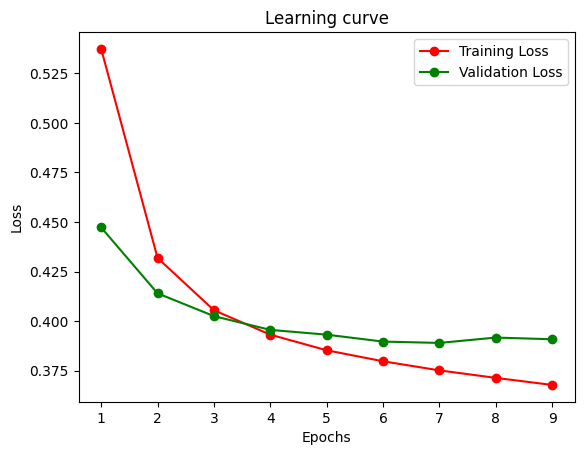

In [ ]:
# Plot the learning curve
plt.plot(epochs, train_losses,"o-", color="red" ,label='Training Loss')
plt.plot(epochs, val_losses, "o-", color="g",label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Learning curve')
plt.legend()
plt.show()

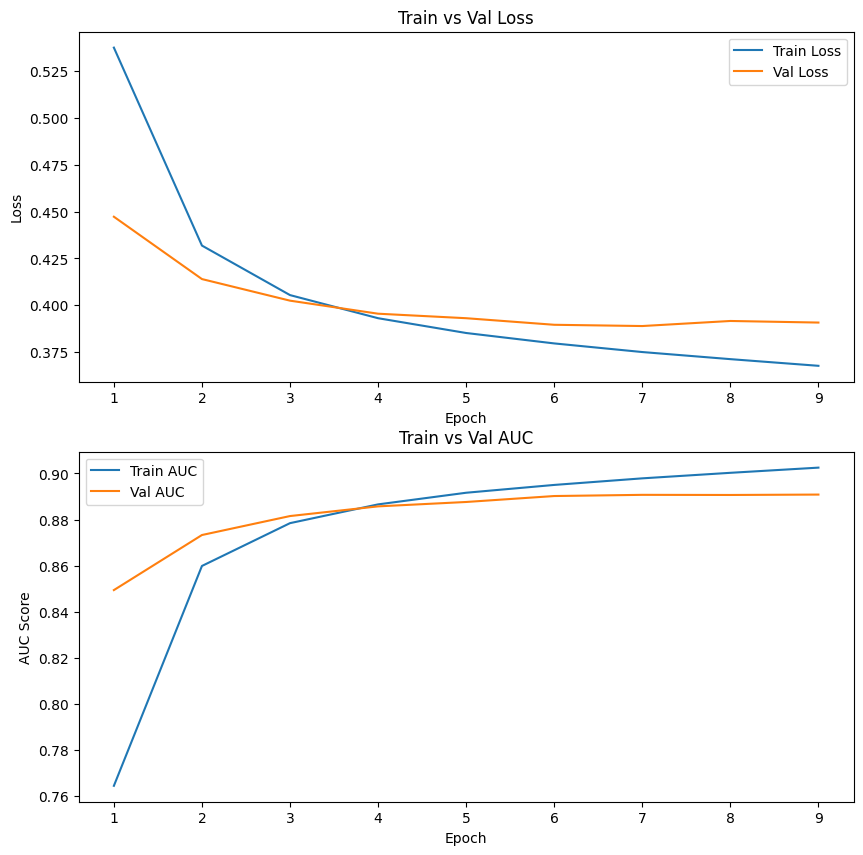

In [ ]:
# Plot the train and validation losses and AUC scores

fig, axs = plt.subplots(2, figsize=(10, 10))
axs[0].plot(epochs, train_losses, label="Train Loss")
axs[0].plot(epochs, val_losses, label="Val Loss")
axs[0].set_title("Train vs Val Loss")
axs[0].set_xlabel("Epoch")
axs[0].set_ylabel("Loss")
axs[0].legend()

axs[1].plot(epochs, train_auc_scores, label="Train AUC")
axs[1].plot(epochs, val_auc_scores, label="Val AUC")
axs[1].set_title("Train vs Val AUC")
axs[1].set_xlabel("Epoch")
axs[1].set_ylabel("AUC Score")
axs[1].legend()

plt.show()

Provo fine-tuning

In [ ]:
# Define the parameter space to explore
learning_rates = [0.1, 0.01, 0.001, 0.0001]

num_neurons_per_layer = [32, 64,128]

# Initialize the lists to store the results
best_params = None
best_val_loss = float('inf')
train_losses = []
val_losses = []

# Loop over all the possible combinations of the parameters
for lr in learning_rates:
    for nn in num_neurons_per_layer:
            # Define the model
            model = Model(hidden_channels=nn)
            model.to(device)

            # Define the optimizer
            optimizer = torch.optim.Adam(model.parameters(), lr=lr)

            # Train loop
            for epoch in range(1, 5):
                total_loss = total_examples = 0
                for sampled_data in tqdm.tqdm(train_loader):
                    optimizer.zero_grad()

                    # Move `sampled_data` to the respective `device`
                    sampled_data.to(device)

                    # Run `forward` pass of the model
                    pred = model(sampled_data)

                    ground_truth = sampled_data.edge_label

                    # Apply binary cross entropy via `F.binary_cross_entropy_with_logits(pred, ground_truth)`
                    loss = F.binary_cross_entropy_with_logits(pred, ground_truth)

                    loss.backward()
                    optimizer.step()
                    total_loss += float(loss) * pred.numel()
                    total_examples += pred.numel()

                # Save the training loss and epoch values
                train_losses.append(total_loss / total_examples)

                # Validation loop
                val_loss = 0
                val_examples = 0
                with torch.no_grad():
                    for val_sampled_data1 in tqdm.tqdm(val_loader):
                        # Move `val_sampled_data` to the respective `device`
                        val_sampled_data1.to(device)

                        # Run `forward` pass of the model
                        val_pred = model(val_sampled_data1)

                        val_ground_truth = val_sampled_data1.edge_label

                        # Apply binary cross entropy via `F.binary_cross_entropy_with_logits(val_pred, val_ground_truth)`
                        val_loss += F.binary_cross_entropy_with_logits(val_pred, val_ground_truth).item() * val_pred.numel()
                        val_examples += val_pred.numel()

                # Save the validation loss
                val_losses.append(val_loss / val_examples)

                # Check if the current parameters are the best so far
                if val_losses[-1] < best_val_loss:
                    best_val_loss = val_losses[-1]
                    best_params = {'lr': lr,'nn': nn}

            print(f"Learning rate: {lr}, Num hidden layers: {nl}, Num neurons per layer: {nn}")
            print(f"Training loss: {train_losses[-1]}, Validation loss: {val_losses[-1]}")

print(f"Best parameters: {best_params}, Best validation loss: {best_val_loss}")


Faccio su test set

In [ ]:
# Define the test seed edges:
edge_label_index = test_data["user_id", "stars", "business_id"].edge_label_index
edge_label = test_data["user_id", "stars", "business_id"].edge_label

test_loader = LinkNeighborLoader(
    data=test_data,
    num_neighbors=[20, 10],
    edge_label_index=(("user_id", "stars", "business_id"), edge_label_index),
    edge_label=edge_label,
    batch_size=3*128,
    shuffle=False,
)

sampled_data2 = next(iter(test_loader))

print("Sampled mini-batch:")
print("===================")
print(sampled_data)


assert sampled_data2["user_id", "stars", "business_id"].edge_label_index.size(1) == 3*128
assert sampled_data2["user_id", "stars", "business_id"].edge_label.min() >= 0
assert sampled_data2["user_id", "stars", "business_id"].edge_label.max() <= 1

Sampled mini-batch:
HeteroData(
  user_id={
    node_id=[11532],
    n_id=[11532]
  },
  business_id={
    node_id=[4661],
    x=[4661, 957],
    n_id=[4661]
  },
  (user_id, stars, business_id)={
    edge_index=[2, 13501],
    edge_label=[384],
    edge_label_index=[2, 384],
    e_id=[13501],
    input_id=[128]
  },
  (business_id, rev_stars, user_id)={
    edge_index=[2, 24823],
    e_id=[24823]
  }
)


In [ ]:


preds = []
ground_truths = []
for sampled_data2 in tqdm.tqdm(test_loader):
    with torch.no_grad():
        # Business data to device
        
        sampled_data2.to(device)
        preds.append(model(sampled_data2))
        ground_truths.append(sampled_data2["user_id", "stars", "business_id"].edge_label)

pred = torch.cat(preds, dim=0).cpu().numpy()
ground_truth = torch.cat(ground_truths, dim=0).cpu().numpy()
auc = roc_auc_score(ground_truth, pred)
print()
print(f"Test AUC: {auc:.4f}")

100%|██████████| 543/543 [00:41<00:00, 12.97it/s]



Test AUC: 0.8920


Visualizzo i risultati

In [ ]:
from sklearn.metrics import classification_report

classification_report(ground_truth, (pred > 0.5).astype(int))

print(classification_report(ground_truth, (pred > 0.5).astype(int)))

              precision    recall  f1-score   support

         0.0       0.83      0.94      0.88    138928
         1.0       0.83      0.61      0.70     69464

    accuracy                           0.83    208392
   macro avg       0.83      0.77      0.79    208392
weighted avg       0.83      0.83      0.82    208392



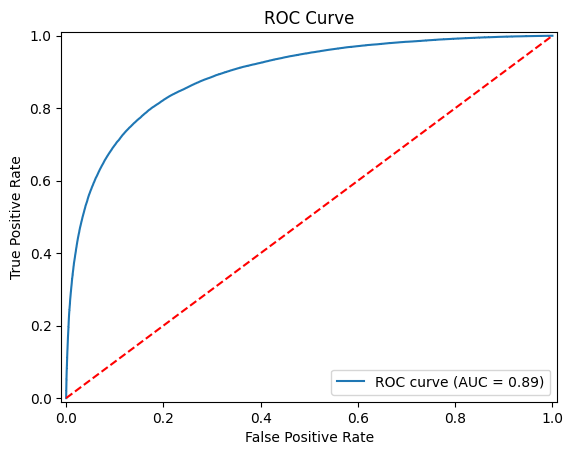

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve

fpr, tpr, _ = roc_curve(ground_truth, pred)

plt.plot(fpr, tpr, label='ROC curve (AUC = {:.2f})'.format(auc))
plt.plot([0, 1], [0, 1],'r--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.show()